# **Introduction** 

This notebook serves as an implementation of the Soft-Actor Critic (SAC) algorithm developed by Haarnoja et al. in the following papers [[1]](https://arxiv.org/abs/1801.01290)[[2]](https://arxiv.org/abs/1812.05905)[[3]](https://arxiv.org/abs/1812.11103). SAC is an off-policy actor-critic algorithm that is based on the maximum entropy reinforcement learning framework.

The maximum entropy framework sees the actor attempting to simultaneously maximize both the expected return and the expected entropy of the policy. This leads to improvements in both exploration and robustness. The three key components of the SAC architecture are:

1. an actor-critic architecture, separating policy and value function into two distinct networks,
2. an off-policy formulation allowing the use of a replay buffer, and
3. the use of entropy maximization to encourage both stability and exploration.

A fourth feature was added in [[2]](https://arxiv.org/abs/1812.05905), which includes automatically adjusting the entropy such that the *temperature* parameter $\alpha$ is learned.

This implementation was done using the `InvertedPendulum` environment offered through `Gymnasium`.

# **Import Packages**

This section imports the necessary packages for this implementation.

In [161]:
# import these:
import gymnasium as gym
import numpy as np
import os
import random
from collections import deque
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import matplotlib.pyplot as plt

function for making neural networks:

In [162]:
# function for making a keras model based on user inputs:
def make_model(rate : float, 
               layers : int, 
               neurons : int, 
               input_shape : int, 
               output_shape : int, 
               loss_function : str, 
               output_activation : str):
    """ 
    this is a function for making simple Keras sequential models. these models do not have any protection
    against vanishing or exploding gradients (lacking batch_normalization and dropout layers, namely) and are
    simply fully connected, nonlinearly activated feedforward neural networks.

    rate:                   a float representing the learning rate of the optimizer used, which is Adam
    layers:                 an int representing the number of layers in the network
    neurons:                an int representing the number of neurons in each layer of the network
    input_shape:            an int representing the shape of the input data (input_shape, )
    output_shape:           an int representing the number of outputs of the network
    loss_function:          a string representing the desired loss function to be used in the optimizer, which is Adam
    output_activation:      a string representing the activation function of the output layer
    
    """
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))
        else: 
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))

    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    # return to user:
    return model

object oriented function for making SAC agents:

In [163]:
# define class:
class SAC_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self,
                env: gym.Env,
                lr_a: float,
                lr_c: float,
                lr_t: float,
                alpha: float,
                gamma: float,
                layers: int,
                neurons: int,
                batch_size: int,
                buffer_size: int,
                gradient_steps: int,
                polyak_coefficient: float,
                target_update_interval: int,
                ):
        """ 
        this is the constructor for the agent. this agent uses the soft actor-critic (SAC) algorithm to learn an optimal policy. 
        the theory behind this implementation is derived from entropy maximization reinforcement learning, which seeks to improve the robustness and the 
        exploratory nature of the agent by changing the learning objective to both maximize the expected return and the entropy. 

        the base SAC implementation in [1] is brittle with respect to the temperature. this is because the SAC algorithm is very sensitive to the scaling of the 
        rewards, and the reward scaling is inversely proportional to temperature, which determines the relative importance of the entropy term versus the reward.

        the modified implementation in [2] addresses this delicate need to tune the temperature by having the network automatically learn the temperature. basically,
        the learning objective is modified to include an expected entropy constraint. the learned stochastic policy therefore attempts to achieve maximal expected return, 
        satisfying a minimum expected entropy constraint. 

        env:                        a gymnasium environment
        lr_a:                       a float value representing the learning rate of the actor, α_a
        lr_c:                       a float value representing the learning rate of the critic, α_c
        lr_t:                       a float value representing the learning rate of the temperature, which is given by α
        alpha:                      a float value representing the initial temperature, α
        gamma:                      a float value representing the discount factor, γ
        layers:                     an int value indicating the number of layers in a given network
        neurons:                    an int value indicating the number of neurons in a given network
        batch_size:                 an int value indicating the number of samples to sample from the replay buffer
        buffer_size:                an int value indicating the size of the replay buffer
        gradient_steps:             an int value indicating how many gradient steps to apply
        polyak_coefficient:         a float value indicating the target smooth coefficient (polyak coefficient)
        target_update_interval:     an int value indicating how often to apply the smooth target network update

        nS:                 an int representing the number of states observed from the continuous state space
        nA:                 an int representing the number of actions observed from the continuous action space
        actor:              a Keras sequential neural network representing the actor network
        critic_1:           a Keras sequential neural network representing the first critic network
        critic_2:           a Keras sequential neural network representing the second critic network
        experience:         an empty deque used to hold the experience history of the agent, limited by 'buffer_size'
        entropy_target:     an int value representing the desired entropy target

        """
        # object parameters:
        self.env = env
        self.lr_a = lr_a
        self.lr_c = lr_c
        self.lr_t = lr_t
        self.gamma = gamma
        self.layers = layers
        self.neurons = neurons
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.gradient_steps = gradient_steps
        self.polyak_coefficient = polyak_coefficient
        self.target_update_interval = target_update_interval

        # set temperature as learnable parameter:
        self.log_alpha = tf.Variable(np.log(alpha), dtype = tf.float32)     # log alpha used to maintain positive entropy
        self.alpha = tf.exp(self.log_alpha)
        self.temp_optimizer = Adam(learning_rate = self.lr_t)

        # get the environmental dimensions (number of states and number of actions):
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.shape[0]
        self.entropy_target = -self.nA      # see appendix D in [2]

        # create networks:
        # ACTOR NETWORK:
        x = Input(shape = (self.nS, ))
        for i in range(self.layers):
            if i == 0:
                h = Dense(self.neurons, activation = "relu")(x)
            else:
                h = Dense(self.neurons, activation = "relu")(h)
        
        # make heads:
        mu = Dense(self.nA, activation = "tanh")(h)
        log_sigma = Dense(self.nA, activation = "linear")(h)

        self.actor = keras.Model(inputs = x, outputs = [mu, log_sigma])
        self.actor.compile(optimizer = Adam(self.lr_a), loss = lambda y_true, y_pred: 0.0)
        
        # NETWORK PAIR 1:
        self.critic_1 = make_model(rate = self.lr_c,
                            layers = self.layers,
                            neurons = self.neurons,
                            input_shape = self.nS + self.nA,
                            output_shape = 1,
                            loss_function = "mse",
                            output_activation = "linear")
        
        self.target_1 = keras.models.clone_model(self.critic_1)
        self.target_1.set_weights(self.critic_1.get_weights())
        
        # NETWORK PAIR 2:
        self.critic_2 = make_model(rate = self.lr_c,
                            layers = self.layers,
                            neurons = self.neurons,
                            input_shape = self.nS + self.nA,
                            output_shape = 1,
                            loss_function = "mse",
                            output_activation = "linear")
        
        self.target_2 = keras.models.clone_model(self.critic_2)
        self.target_2.set_weights(self.critic_2.get_weights())
        
        # initialize the experience buffer:
        self.experience = deque(maxlen = self.buffer_size)

        # initialize the step counter:
        self.step_counter = 0

    ####################### TRAINING #######################
    # critic updating function:
    @tf.function
    def critic_update(self, states, rewards, actions, next_states, dones):
        with tf.GradientTape(persistent = True) as critic_tape:
            # 1) need to sample the next action:
            means, log_stds = self.actor(next_states, training = True)    # get the network output
            log_stds = tf.clip_by_value(log_stds, -20, 2)                 # clamp the log-std to prevent huge/small stds
            stds = tf.exp(log_stds)                                       # convert from log_std to std

            # reparameterize:
            zs = tf.random.normal(tf.shape(means))                              # sample the standard normal distribution
            pre_tanh = means + stds * zs                                        # location-scale from N(0, 1) to N(μ, σ^2), prior to tanh squashing
            next_actions = tf.tanh(pre_tanh)                                    # reparameterize using reparameterization trick
            scaled_next_actions = next_actions * np.array(0.5, dtype = np.float32)     # scale to within the action-space

            # 2) need to compute the log-prob with the tanh correction:
            logp = -0.5 * (zs**2 + 2 * log_stds + np.log(2 * np.pi))    # log-probability of sampling pre-tanh
            logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

            # subtract off the jacobian correction for tanh squashing:
            logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

            # 3) compute target Q value:
            target_input = tf.concat([next_states, scaled_next_actions], axis = 1)      # shape (bS, nS + nA)
            q1_t = self.target_1(target_input, training = True)                         # shape (bS, 1)
            q2_t = self.target_2(target_input, training = True)                         # shape (bS, 1)
            q_t = tf.minimum(q1_t, q2_t)                                                # shape (bS, 1)

            # 4) compute the target:
            target = rewards[:, None] + self.gamma * (1 - dones[:, None]) * (q_t - self.alpha * logp)

            # 5) compute current Q value:
            current_input = tf.concat([states, actions], axis = 1)
            q1 = self.critic_1(current_input, training = True)
            q2 = self.critic_2(current_input, training = True)

            # 6) compute losses:
            critic_loss_1 = tf.reduce_mean((q1 - tf.stop_gradient(target))**2)
            critic_loss_2 = tf.reduce_mean((q2 - tf.stop_gradient(target))**2)
        
        # 7) compute gradients:
        grads_1 = critic_tape.gradient(critic_loss_1, self.critic_1.trainable_variables)
        grads_2 = critic_tape.gradient(critic_loss_2, self.critic_2.trainable_variables)

        # 8) backpropagate:
        self.critic_1.optimizer.apply_gradients(zip(grads_1, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(grads_2, self.critic_2.trainable_variables))

        # due to multiple tape calls, it is not automatically closed -> therefore close tape:
        del critic_tape

    @tf.function
    def actor_update(self, states):
        with tf.GradientTape() as actor_tape:
            # 1) need to sample a fresh action:
            means, log_stds = self.actor(states, training = True)       # get the network output
            log_stds = tf.clip_by_value(log_stds, -20, 2)               # clamp the log-std to prevent huge/small stds
            stds = tf.exp(log_stds)                                     # convert from log_std to std

            # reparameterize:
            zs = tf.random.normal(tf.shape(means))                      # sample the standard normal distribution
            pre_tanh = means + stds * zs                                # location scaale from N(0, 1) to N(μ, σ^2), prior to tanh squashing
            actions = tf.tanh(pre_tanh)                                 # reparameterize using reparameterization trick
            scaled_actions = actions * np.array(0.5, dtype = np.float32)       # scale to within the action-space

            # 2) need to compute the log-prob with the tanh correction:
            logp = -0.5 * (zs**2 + 2*log_stds + np.log(2 * np.pi))      # log-probability of sampling pre-tanh
            logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

            # subtract off the jacobian correction for tanh squashing:
            logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

            # 3) compute a Q-estimate using f | s:
            current_input = tf.concat([states, scaled_actions], axis = 1)   # shape (bS, nS + nA)
            q1 = self.critic_1(current_input, training = True)              # shape (bS, 1)
            q2 = self.critic_2(current_input, training = True)              # shape (bS, 1)
            q = tf.minimum(q1, q2)                                          # shape (bS, 1)

            # 4) compute the actor loss (flipped for ascent):
            actor_loss = tf.reduce_mean(self.alpha * logp - q)

        # 5) compute gradients:
        grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)

        # 6) backpropagate:
        self.actor.optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))

    @tf.function
    def temp_update(self, states):
        # 1) need to sample a fresh action:
        means, log_stds = self.actor(states, training = False)      # get the network output
        log_stds = tf.clip_by_value(log_stds, -20, 2)               # clamp the log-std to prevent huge/small stds
        stds = tf.exp(log_stds)                                     # convert from log_std to std

        # reparameterize:
        zs = tf.random.normal(shape = tf.shape(means))              # sample the standard normal distribution
        pre_tanh = means + stds * zs                                # use location-scaling to go from N(0,1) to N(μ, σ^2)

        # 2) compute the log of the policy:
        logp = -0.5 * (zs**2 + 2*log_stds + np.log(2*np.pi))        # log-probability of sampling pre-tanh
        logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

        # subtract off the jacobian correction for tanh squashing:
        logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

        # 3) compute temperature loss:
        with tf.GradientTape() as temp_tape:
            temp_loss = -tf.reduce_mean(self.log_alpha * (logp + self.entropy_target))
        
        # 4) compute gradient:
        temp_grad = temp_tape.gradient(temp_loss, [self.log_alpha])

        # 5) backpropagate and update:
        self.temp_optimizer.apply_gradients(zip(temp_grad, [self.log_alpha]))
        self.alpha = (tf.exp(self.log_alpha))

    @tf.function
    def polyak_update(self):
        # update the first network:
        for target, online in zip(self.target_1.variables, self.critic_1.variables):
            target.assign(self.polyak_coefficient * online + (1 - self.polyak_coefficient) * target)

        # update the second network:
        for target, online in zip(self.target_2.variables, self.critic_2.variables):
            target.assign(self.polyak_coefficient * online + (1 - self.polyak_coefficient) * target)

    # training function:
    def training(self, training_length, train_metrics):
        """ 
        this is the function that executes the main SAC loop, using gymnasium to interact with the environment
        and collect reward. this function also calls upon the tensorflow decorated training functions to update the 
        networks.

        training_length:        desired number of episodes to train the agent for
        return:                 reward_history, which is the history of reward collected over all episodes
        
        """
        # initialize reward history:
        reward_history = []

        # for every episode:
        for episode in tqdm(range(training_length), ncols = 100, colour = "#33FF00", desc = "training progress"):
            # 0) INITIALIZATION:
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False

            # while False:
            while not done:
                # convert obs to tensor:
                obs_tensor = tf.convert_to_tensor([obs], dtype = tf.float32)

                # 1) GET ACTION:
                mean, log_std = self.actor(obs_tensor)                          # get network output
                log_std = tf.clip_by_value(log_std, -20, 2)                     # clamp the log-std to prevent huge/small stds
                std = tf.exp(log_std)                                           # convert from log_std to std
                z = tf.random.normal(shape = tf.shape(mean))                    # sample the standard normal distribution
                pre_tanh = mean + std*z                                         # use location-scaling to go from N(0,1) to N(μ, σ^2)
                action = tf.tanh(pre_tanh)[0] * np.array(0.5, dtype = np.float32)      # squash using tanh, scale action into action bounds

                # 2) EXECUTE ACTION ON ENVIRONMENT:
                next_obs, reward, term, trunc, _ = self.env.step(action)
                done = term or trunc

                # 3) STORE TRANSITION IN REPLAY BUFFER:
                self.experience.append((obs.copy(), action.numpy(), reward, next_obs.copy(), done))

                # advance:
                obs = next_obs
                episode_reward += reward
                self.step_counter += 1

                # 4) RESET ENVIRONMENT STATE IF TERMINAL:
                if done:
                    break

                # 5) IF TIME TO UPDATE:
                if len(self.experience) >= self.batch_size:
                    # 6) FOR AS MANY UPDATES AS REQUIRED:
                    for _ in range(self.gradient_steps):
                        # 7) SAMPLE A BATCH:
                        batch = random.sample(list(self.experience), self.batch_size)

                        # unpack the batch:
                        states, actions, rewards, next_states, dones = zip(*batch)

                        # convert to tensors:
                        states          = tf.convert_to_tensor(states, dtype = tf.float32)
                        actions         = tf.convert_to_tensor(actions, dtype = tf.float32)
                        rewards         = tf.convert_to_tensor(rewards, dtype = tf.float32)
                        next_states     = tf.convert_to_tensor(next_states, dtype = tf.float32)
                        dones           = tf.convert_to_tensor(dones, dtype = tf.float32)

                        # 8) GRADIENT STEP TO UPDATE NETWORKS:
                        self.critic_update(states, rewards, actions, next_states, dones)

                        if int(self.step_counter) % 2 == 0:
                            self.actor_update(states)
                            self.temp_update(states)
                            
                        self.polyak_update()

            # 9) ADVANCE REWARD HISTORY:
            reward_history.append(episode_reward)

            # 10) CHECK FOR EARLY STOPPING:
            if len(reward_history) >= train_metrics["min_train"]:
                # compute a recent average:
                recent_average = np.mean(reward_history[-train_metrics["over_last"]:]).round(3)

                # if the recent average is above the desired threshold:
                if recent_average >= train_metrics["desired_score"]:
                    print(f"environment solved in {len(reward_history)} episodes!")
                    print(f"average reward was: {recent_average}")

                    # save weights:
                    os.makedirs(train_metrics["model_path"], exist_ok = True)
                    try:
                        # paths:
                        actor_path = f"{train_metrics["model_path"]}/actor_weights.weights.h5"
                        critic_path_1 = f"{train_metrics["model_path"]}/critic_1_weights.weights.h5"
                        critic_path_2 = f"{train_metrics["model_path"]}/critic_2_weights.weights.h5"

                        # save weights:
                        self.actor.save_weights(actor_path)
                        self.critic_1.save_weights(critic_path_1)
                        self.critic_2.save_weights(critic_path_2)
                    except Exception as e:
                        print(f"failed to save model: {e}")
                    break

        return reward_history         

define stuff:

In [164]:
# define hyperparameters:
lr_a = 3e-4
lr_c = 3e-4
lr_t = 3e-4
alpha = 0.01
gamma = 0.99
layers = 3
neurons = 128
batch_size = 256
buffer_size = int(1e6)
gradient_steps = 1
polyak_coefficient = 0.005
target_update_interval = 1

warmup_length = 10000
training_length = 1000

# training parameters:
desired_score = 975
over_last = 100
min_train = 100

base_path = os.path.join(os.getcwd(), "weights")
model_path = os.path.join(base_path, f"inverted_pendulum_{len(os.listdir(base_path)) + 1}")

train_metrics = {"desired_score" : desired_score,
                 "over_last"     : over_last,
                 "min_train"     : min_train,
                 "model_path"    : model_path}

In [165]:
# clear backend:
tf.keras.backend.clear_session()

# make env:
env = gym.make("InvertedPendulum-v5")

# make agent:
agent = SAC_Agent(env = env, 
                  lr_a = lr_a, 
                  lr_c = lr_c,
                  lr_t = lr_t,
                  alpha = alpha,
                  gamma = gamma, 
                  layers = layers, 
                  neurons = neurons, 
                  batch_size = batch_size, 
                  buffer_size = buffer_size, 
                  gradient_steps = gradient_steps,
                  polyak_coefficient = polyak_coefficient, 
                  target_update_interval = target_update_interval
                  )

need to warm up the replay buffer:

In [166]:
# initialize:
obs, _ = agent.env.reset()
obs_tensor = tf.convert_to_tensor([obs], dtype = tf.float32)

# generate trajectories:
for _ in tqdm(range(warmup_length), ncols = 100, colour = "#33FF00", desc = "warmup progress"):
    # 1) SAMPLE A RANDOM ACTION:
    mean, log_std = agent.actor(obs_tensor)                         # get network output
    log_std = tf.clip_by_value(log_std, -20, 2)                     # clamp the log-std to prevent huge/small stds
    std = tf.exp(log_std)                                           # convert from log_std to std
    z = tf.random.normal(shape = tf.shape(mean))                    # sample the standard normal distribution
    pre_tanh = mean + std*z                                         # use location-scaling to go from N(0,1) to N(μ, σ^2)
    action = tf.tanh(pre_tanh)[0] * np.array(0.5, dtype = np.float32)     # squash action using tanh, scale action into action bounds

    # 2) ACT ON THE ENVIRONMENT:
    next_obs, reward, term, trunc, _ = agent.env.step(action)

    # 3) CHECK FOR COMPLETION:
    done = term or trunc

    # 4) APPEND TO BUFFER:
    agent.experience.append((obs.copy(), action.numpy(), reward, next_obs.copy(), done))
    obs = next_obs if not done else agent.env.reset()[0]

warmup progress: 100%|███████████████████████████████████████| 10000/10000 [00:22<00:00, 438.33it/s]


train:

In [167]:
reward_history = agent.training(training_length = training_length, train_metrics = train_metrics)

training progress:  34%|██████████████▏                          | 345/1000 [15:07<28:42,  2.63s/it]

environment solved in 346 episodes!
average reward was: 979.53


plotting the results:

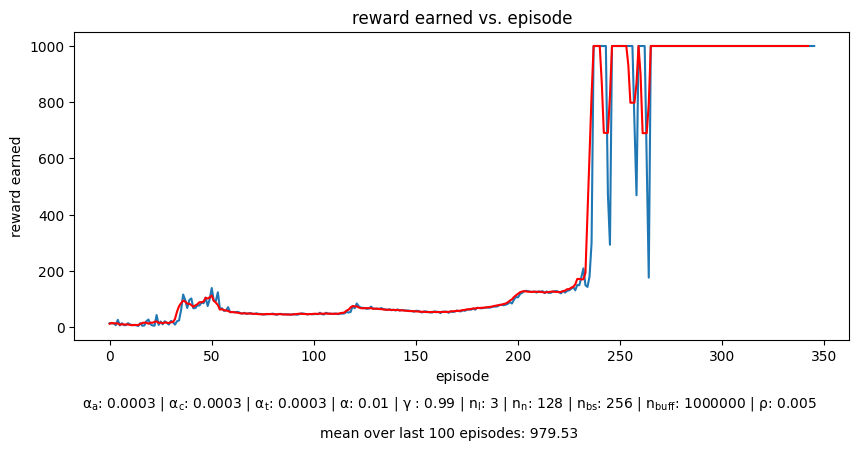

In [168]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')

filtered_data = moving_average(reward_history, 4)
last_few = np.mean(reward_history[-over_last:]).round(3)

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on
plt.title('reward earned vs. episode')
plt.xlabel('episode')
plt.ylabel(f'reward earned')
plt.figtext(x = 0.5, y = -0.05, s = fr"$\mathrm{{\alpha_a}}$: {lr_a} | $\mathrm{{\alpha_c}}$: {lr_c} | $\mathrm{{\alpha_t}}$: {lr_t} | $\mathrm{{\alpha}}$: {alpha} | $\mathrm{{\gamma}}$ : {gamma} | $\mathrm{{n_l}}$: {layers} | $\mathrm{{n_n}}$: {neurons} | $\mathrm{{n_{{bs}}}}$: {batch_size} | $\mathrm{{n_{{buff}}}}$: {buffer_size} | $\mathrm{{\rho}}$: {polyak_coefficient}", ha = 'center', va = 'center')
plt.figtext(x = 0.5, y = -0.125, s = fr"mean over last {over_last} episodes: {last_few}", ha = 'center', va = 'center')

# save figure:
if len(model_path) != 0:
    try:
        plt.savefig(f"{model_path}/reward_episode_plot.png", bbox_inches = 'tight')
    except Exception as e:
        print(f"could not save: {e}")

visualize:

In [171]:
visualize = True

if visualize:
    env = gym.make("InvertedPendulum-v5", render_mode = "human")

    agent.env = env

    obs, _ = agent.env.reset()
    done = False
    
    while not done:
        agent.env.render()

        obs_tensor = tf.convert_to_tensor([obs], dtype = tf.float32)

        # 1) SAMPLE A RANDOM ACTION:
        mean, log_std = agent.actor(obs_tensor)                         # get network output
        log_std = tf.clip_by_value(log_std, -20, 2)                     # clamp the log-std to prevent huge/small stds
        std = tf.exp(log_std)                                           # convert from log_std to std
        z = tf.random.normal(shape = tf.shape(mean))                    # sample the standard normal distribution
        pre_tanh = mean + std*z                                         # use location-scaling to go from N(0,1) to N(μ, σ^2)
        action = tf.tanh(pre_tanh)[0] * np.array(0.5, dtype = np.float32)     # squash action using tanh, scale action into action bounds

        # 2) DO ACTION:
        next_obs, reward, term, trunc, _ = agent.env.step(action)

        # 3) ADVANCE:
        obs = next_obs

        # 4) CHECK FOR COMPLETION:
        done = term or trunc
    
    agent.env.close()
